In [63]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import olac.maths as mf

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
arr1 = np.random.normal(0, 1, size=10000)

In [74]:
arr2 = np.random.normal(0.8, 1.3, size=10000)

KL divergence score: 0.36903500933445693 

Hellinger distance: 0.26912346791776853 



KL divergence score: 0.36903500933445693 

Hellinger distance: 0.26912346791776853 



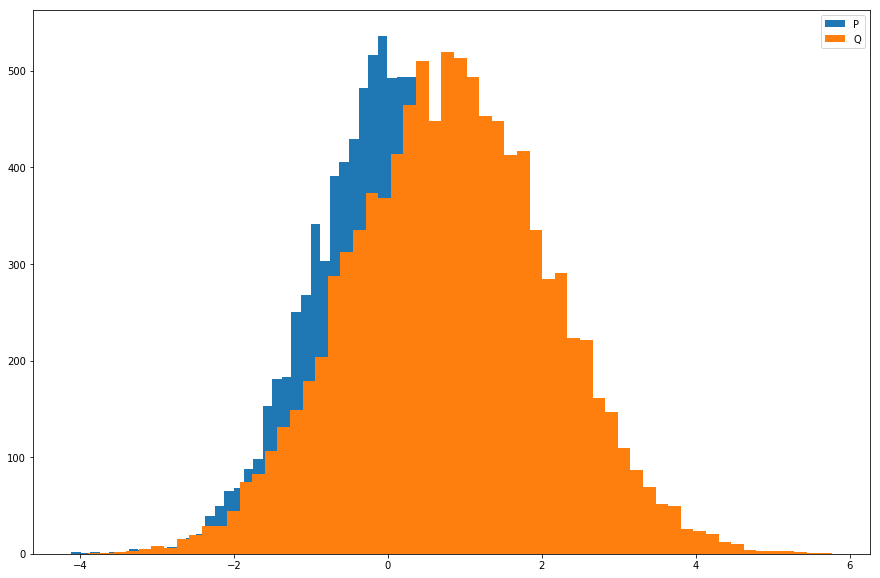

In [81]:
print('KL divergence score: {} \n'.format(mf.KL_div(arr1, arr2)))
print('Hellinger distance: {} \n'.format(mf.hellinger_dist(arr1, arr2)))
plt.figure(figsize=(15, 10))
plt.hist(arr1, label='P', bins=mf.auto_bin(arr1));
plt.hist(arr2, label='Q', bins=mf.auto_bin(arr2));
plt.legend();

In [115]:
arr1 = np.random.normal(0, 1, size=10000)
mu_sample = np.random.lognormal(0, 2, size=1000)
kl = []
hd = []
for mu in mu_sample:
    arr2 = np.random.normal(mu, 1, size=10000)
    kls = mf.kl_div(arr1, arr2)
    hds = mf.hellinger_dist(arr1, arr2)
    kl.append(kls)
    hd.append(hds)
    #print('mu: {}'.format(mu))
    #print('KL divergence score: {}'.format(kls))
    #print('Hellinger distance: {}'.format(hds))
    #print()

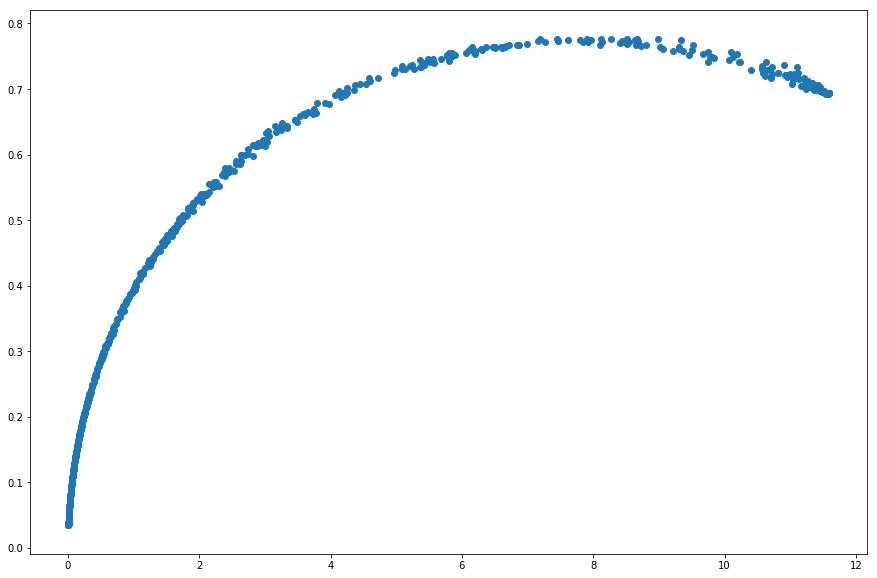

In [116]:
plt.figure(figsize=(15, 10))
plt.scatter(kl, hd)